In [406]:
%cd ../..
%load_ext autoreload
%autoreload 2

import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from pipeline import lab, get_schema_name, experiment, foraging_model, ephys, foraging_analysis, histology, ccf, report, psth_foraging
from pipeline.plot import behavior_plot, unit_characteristic_plot, unit_psth, histology_plot, PhotostimError, foraging_plot
from pipeline.plot.foraging_model_plot import plot_session_model_comparison, plot_session_fitted_choice, plot_unit_all_in_one

foraging_sessions = (foraging_analysis.SessionTaskProtocol & 'session_task_protocol=100').proj()
import datajoint as dj; dj.conn().connect()

cache_folder = '~/s3-drive/report/st_cache/'

/
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get meta info

In [2]:
foraging_sessions = (foraging_analysis.SessionTaskProtocol & 'session_task_protocol in (100, 110, 120)').proj()
if_photostim_from_behav = foraging_sessions.aggr(foraging_sessions * experiment.PhotostimForagingTrial, ...,
                                      keep_all_rows=True, photostim_behav='IF(COUNT(trial)>0, "yes", "no")')
if_photostim_from_ephys = foraging_sessions.aggr(foraging_sessions * (ephys.TrialEvent & 'trial_event_type LIKE "laser%"'), ...,
                                      keep_all_rows=True, photostim_NI='IF(COUNT(trial)>0, "yes", "no")')

q = ((experiment.Session & foraging_sessions)
                            * lab.WaterRestriction.proj(h2o='water_restriction_number')
                            * if_photostim_from_behav
                            * if_photostim_from_ephys
    & 'photostim_behav = "yes"').proj(..., '-rig', '-username', '-session_time')
df_sessions = pd.DataFrame(q.fetch())
photostim_behavior = df_sessions.query('photostim_behav == "yes"')
photostim_behavior

,subject_id,session,session_date,h2o,photostim_behav,photostim_NI
0,494691,19,2021-12-10,HH16,yes,no
1,494694,21,2021-12-16,HH18,yes,yes
2,494694,20,2021-12-15,HH18,yes,yes
3,494694,19,2021-12-14,HH18,yes,yes
4,494694,18,2021-12-13,HH18,yes,yes
...,...,...,...,...,...,...
75,646196,41,2023-02-01,XY_09,yes,no
76,646196,40,2023-01-31,XY_09,yes,no
77,646196,39,2023-01-30,XY_09,yes,no
78,646196,38,2023-01-27,XY_09,yes,no


In [3]:
q_xy_10 = q & 'h2o = "XY_10"'
q_xy_10

subject_id institution 6 digit animal ID,session session number,session_date,h2o WR number,photostim_behav calculated attribute,photostim_NI calculated attribute
643252,41,2023-02-09,XY_10,yes,no
643252,40,2023-02-08,XY_10,yes,no
643252,39,2023-02-07,XY_10,yes,no
643252,38,2023-02-02,XY_10,yes,no
643252,37,2023-02-01,XY_10,yes,no
643252,36,2023-01-31,XY_10,yes,no
643252,35,2023-01-30,XY_10,yes,no
643252,34,2023-01-27,XY_10,yes,no
643252,33,2023-01-26,XY_10,yes,no
643252,32,2023-01-25,XY_10,yes,no


# Session-wise

## Event plot

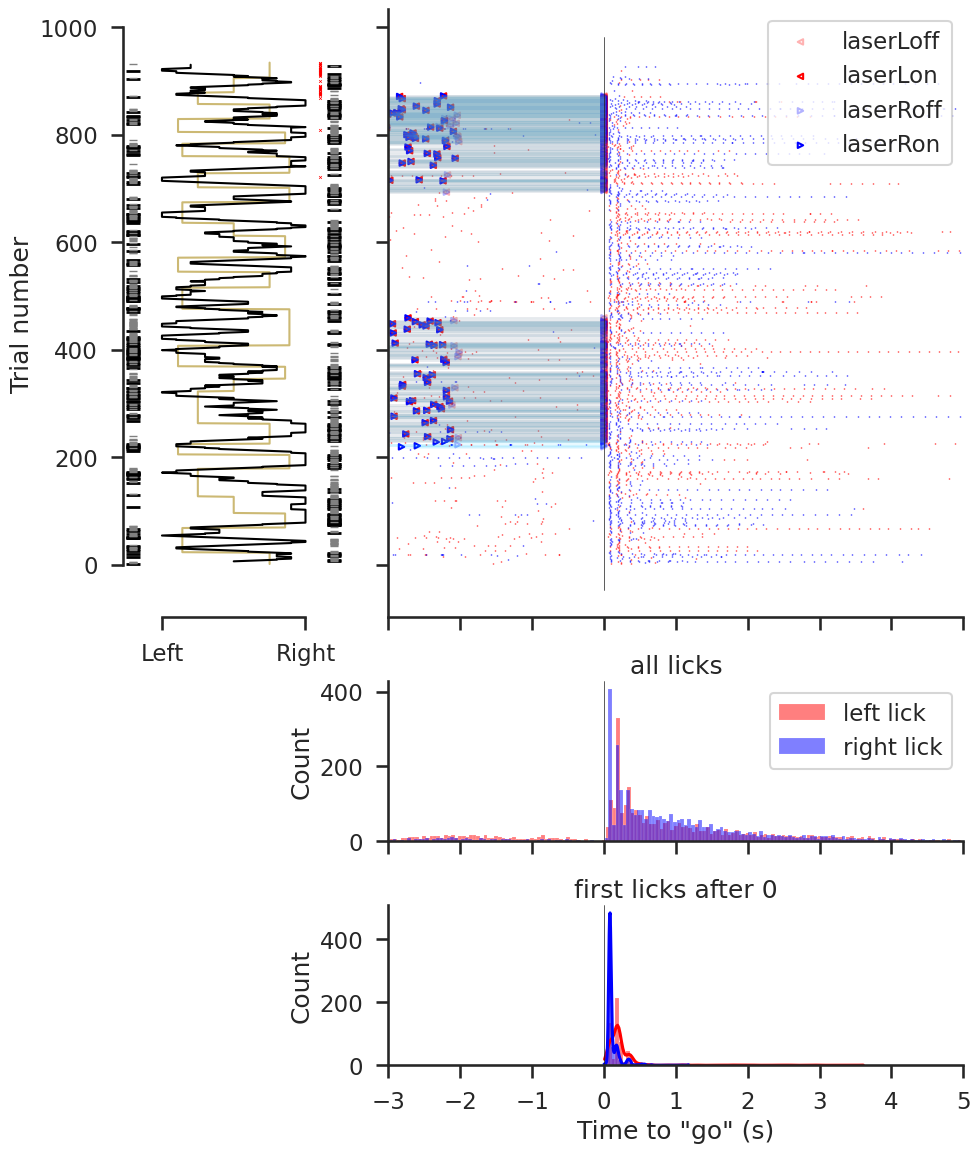

In [367]:
key = {'subject_id': 643252, 'session': 33}
foraging_plot.plot_lick_psth(key)

{'subject_id': 643252, 'session': 40}


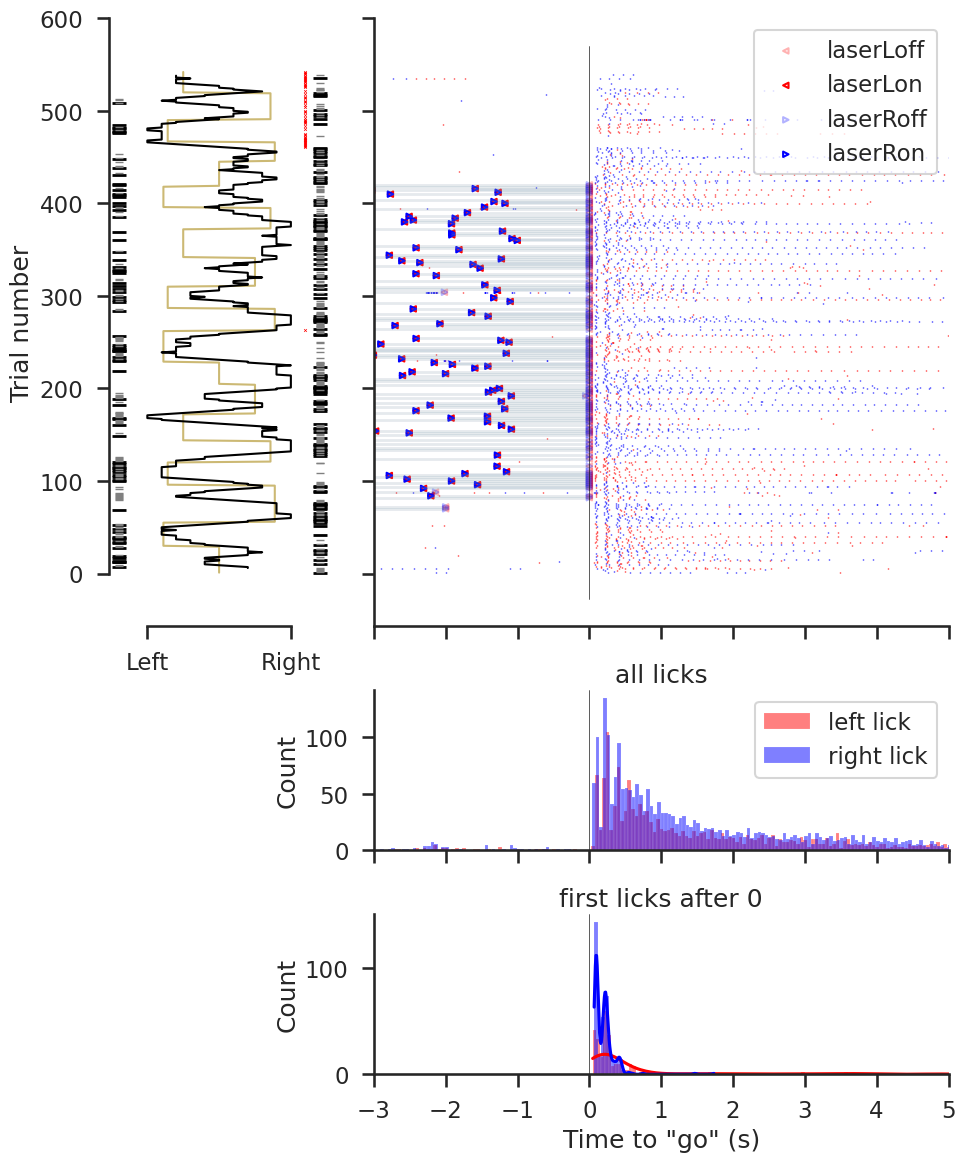

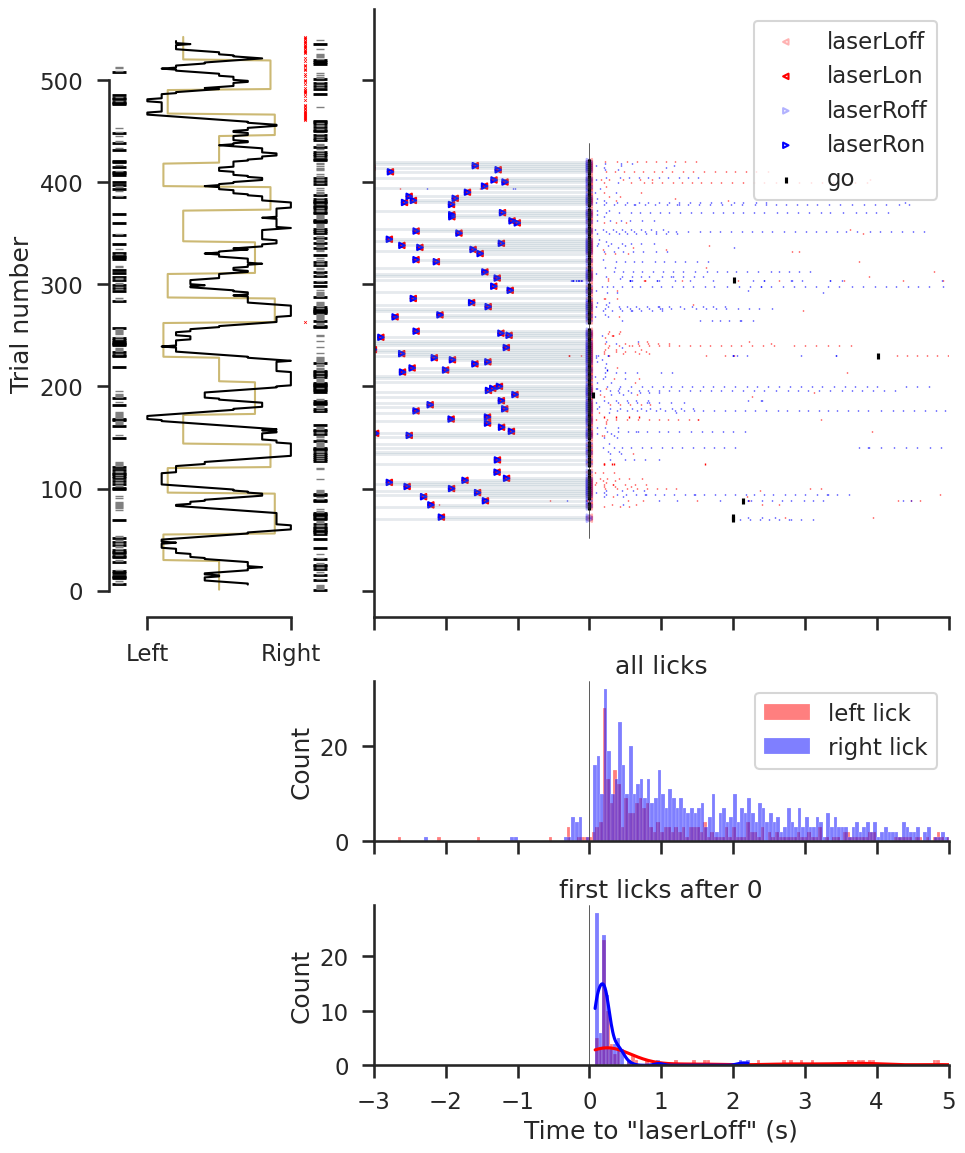

In [373]:
for key in q_xy_10.fetch('KEY', order_by='session')[-2:-1]:
    print(key)
    foraging_plot.plot_lick_psth(key)
    foraging_plot.plot_lick_psth(key, trial_event_to_align='laserLoff', other_trial_events={'laserLoff': ('None', '<'), 'laserLon': ('None', '<'), 'laserRoff': ('None', '>'), 'laserRon': ('None', '>'), 'go': ('black', '|')})

In [5]:
experiment.PhotostimForagingTrial.heading

# 
subject_id           : int                          # institution 6 digit animal ID
session              : smallint                     # session number
trial                : smallint                     # trial number (1-based indexing)
photostim_event_id   : smallint                     # Same as PhotostimEvent (just in case there is one-to-many mapping)
---
side                 : smallint                     # 0: Left only, 1: Right only, 2: Bilateral
power                : decimal(8,3)                 # (mW) measured power of the sinusoid wave
on_to_go_cue         : decimal(8,4)                 # (s) from go cue of this trial
off_to_go_cue        : decimal(8,4)                 # (s) from go cue of this trial
duration             : decimal(8,4)                 # 
ramping_down         : decimal(8,4)                 # (s) ramping down duration
bpod_timer_align_to=null : varchar(30)                  # 
bpod_timer_offset=null : decimal(8,4)                 # From bpod protocol

In [4]:
from pipeline.model import descriptive_analysis
from pipeline.foraging_model import get_session_history

In [374]:
c, r, _, p, _ = get_session_history(key, remove_ignored=True)
choice = c[0]
reward = np.sum(r, axis=0)

In [130]:
len(choice)

753

All trials

Photostim trials

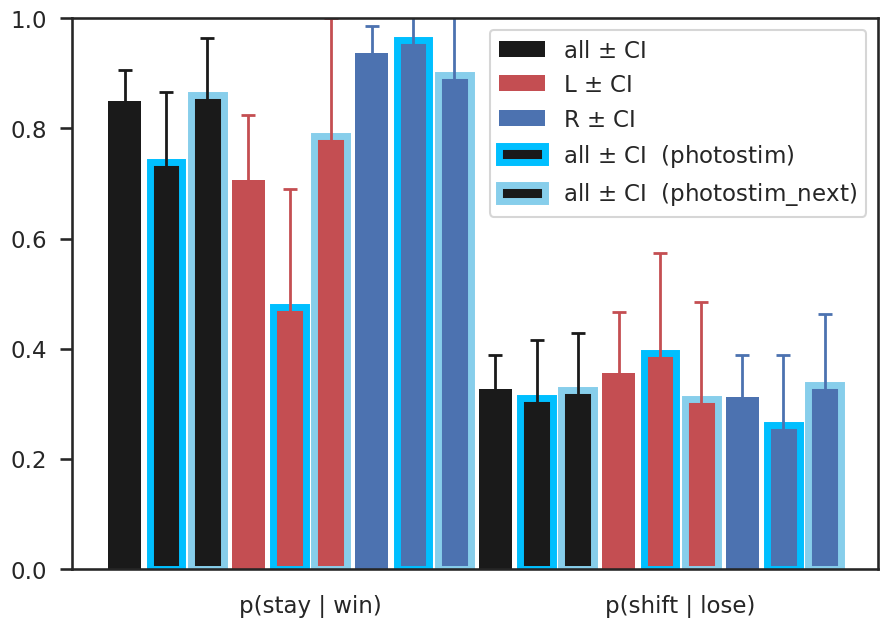

In [377]:
non_ignore_trial = (experiment.BehaviorTrial & key & 'outcome != "ignore"').fetch('trial')
photostim_trial = (experiment.PhotostimForagingTrial & (experiment.BehaviorTrial & key & 'outcome != "ignore"')).fetch('trial')

photostim_trial_in_non_ignore = np.nonzero(np.in1d(non_ignore_trial, photostim_trial))[0]   # np.searchsorted(non_ignore_trial, photostim_trial)
ctrl_trial_in_non_ignore = np.nonzero(~np.in1d(non_ignore_trial, photostim_trial))[0] 

p_wsls_ctrl = descriptive_analysis.win_stay_lose_shift(choice, reward, selected_trial_idx=ctrl_trial_in_non_ignore)
p_wsls_photostim = descriptive_analysis.win_stay_lose_shift(choice, reward, selected_trial_idx=photostim_trial_in_non_ignore)
p_wsls_photostim_next = descriptive_analysis.win_stay_lose_shift(choice, reward, selected_trial_idx=photostim_trial_in_non_ignore + 1)

ax = descriptive_analysis.plot_wsls([p_wsls_ctrl, p_wsls_photostim, p_wsls_photostim_next], edgecolors=['None', 'deepskyblue', 'skyblue'], labels=['', ' (photostim)', ' (photostim_next)'])
h, l = ax.get_legend_handles_labels()
l_to_show = np.r_[:4, 6]
ax.legend([h[i] for i in l_to_show], [l[i] for i in l_to_show])
# ax.set_ylim([0, 1.1])

[<AxesSubplot:title={'center':'control trials (n=727)'}, xlabel='Past trials', ylabel='Logistic regression coeffs'>,
 <AxesSubplot:title={'center':'photostim trials (n=183, 20.11%)'}, xlabel='Past trials'>,
 <AxesSubplot:>]

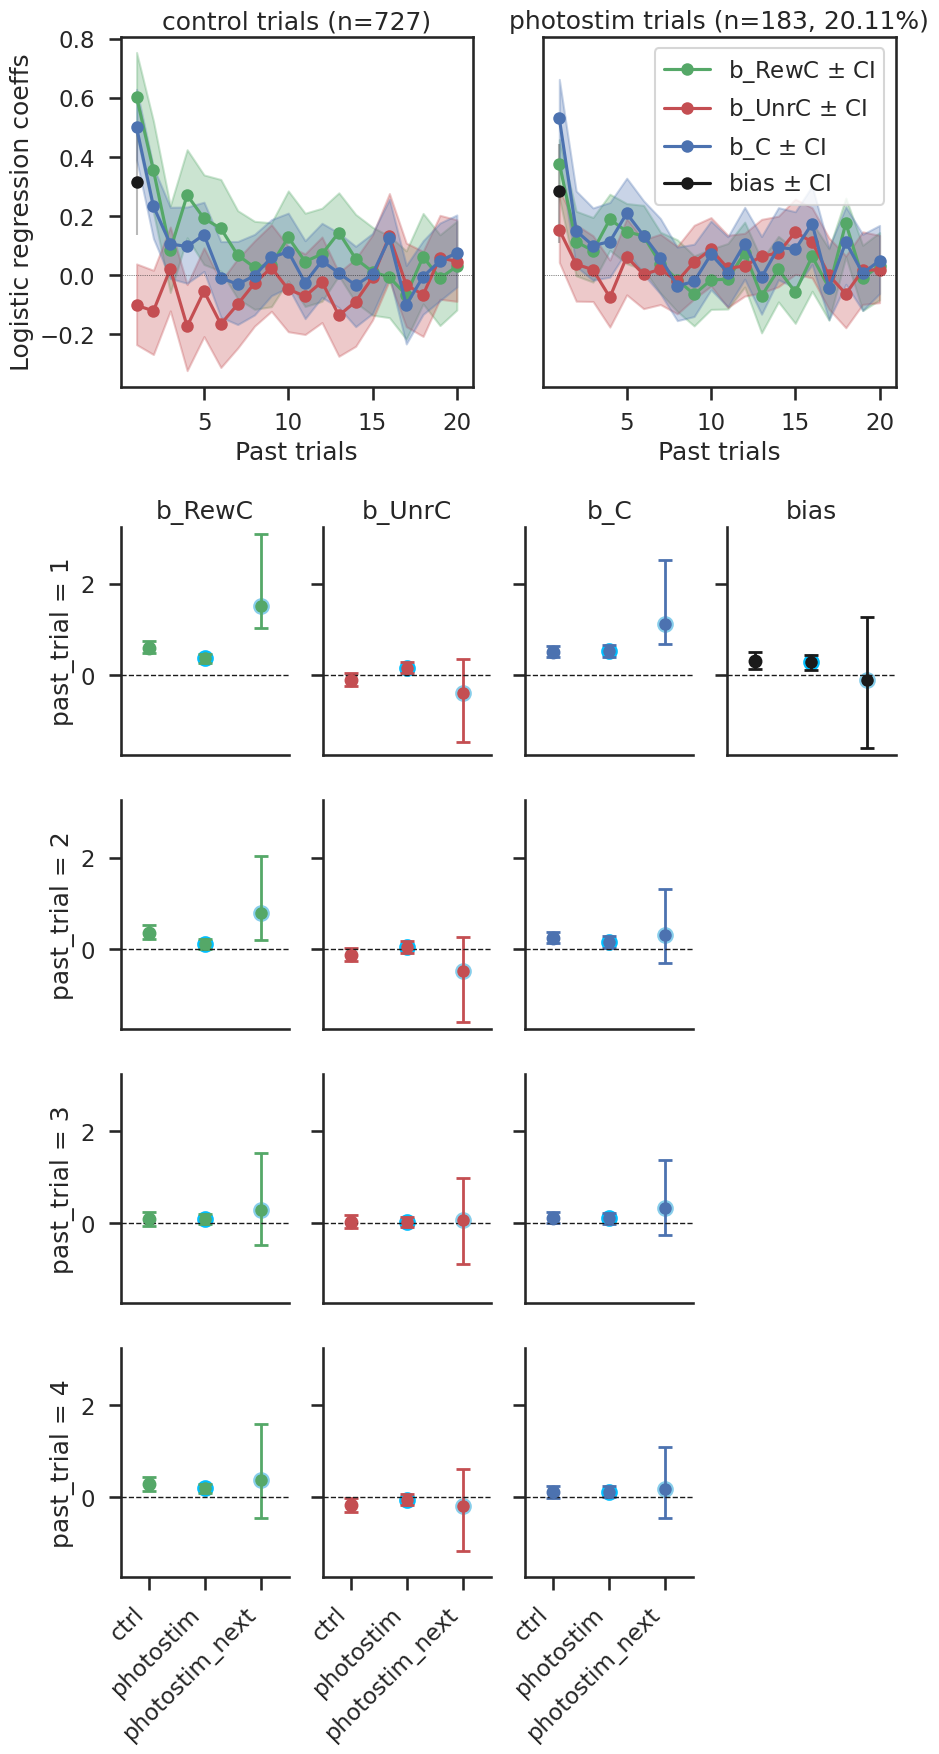

In [425]:
from pipeline.plot import foraging_model_plot
foraging_model_plot.plot_session_logistic({'subject_id': 643252, 'session': 39})